In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():
    
    def __init__(self, arm_index, d, alpha):
        self.arm_index = arm_index
        self.alpha = alpha
        self.A = np.identity(d)
        self.b = np.zeros([d,1])
        self.theta = np.zeros([d,1])
        
    def calc_UCB(self, x_array):
        A_inv = np.linalg.inv(self.A)
        self.theta = np.dot(A_inv, self.b)
        x = x_array.reshape([-1,1])

        p = np.dot(self.theta.T,x) +  self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv,x)))
        
        return p
    
    def reward_update(self, reward, x_array):
        x = x_array.reshape([-1,1])
    
        self.A += np.dot(x, x.T)
        self.b += reward * x 

In [5]:
from typing import Optional

class linucb_policy():
    
    def __init__(self, K_arms, d, alpha, linucb_arms : Optional[list] = None):
        self.K_arms = K_arms
        if linucb_arms is None:
            self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]
        else:
            self.linucb_arms = linucb_arms
        
    def select_arm(self, x_array):
        highest_ucb = -1
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)

            if arm_ucb > highest_ucb:
                highest_ucb = arm_ucb
                candidate_arms = [arm_index]

            if arm_ucb == highest_ucb:
                
                candidate_arms.append(arm_index)

        chosen_arm = np.random.choice(candidate_arms)
        
        return chosen_arm

In [6]:
def train_linucb(K_arms, d, alpha, data_path):
    linucb_policy_object = linucb_policy(K_arms = K_arms, d = d, alpha = alpha)

    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    probability = []
    total_steps = 0
    total_regret = 0
    regret = []
    unaligned_ctr = [] # for unaligned time steps

    with open(data_path, "r") as f:

        for i, line_data in enumerate(f):
            if i >= 1000:
                break
            data_arm = int(line_data.split()[-1])

            covariate_string_list = line_data.split()[:-1]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

            arm_index = linucb_policy_object.select_arm(data_x_array)
            total_steps += 1
            if arm_index == data_arm:

                linucb_policy_object.linucb_arms[arm_index].reward_update(float(1), data_x_array)
                aligned_time_steps += 1
            else:
                linucb_policy_object.linucb_arms[arm_index].reward_update(float(0), data_x_array)
                total_regret += 1
            
            probability.append(aligned_time_steps/total_steps)
            regret.append(total_regret/total_steps)
                    
    return (probability, aligned_time_steps, cumulative_rewards, aligned_ctr, regret, linucb_policy_object)

In [7]:
def test_linucb(data_path, policy):
    probability = []
    regret = []
    total_steps = 0
    correct = 0
    incorrect = 0
    with open(data_path, "r") as f:

        for i, line_data in enumerate(f):
            if i >= 1000:
                total_steps += 1
                data_arm = int(line_data.split()[-1])

                covariate_string_list = line_data.split()[:-1]
                data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])
                arm_index = policy.select_arm(data_x_array)

                if arm_index == data_arm:
                    correct += 1
                else:
                    incorrect += 1

                probability.append(correct/total_steps)
                regret.append(incorrect/total_steps)
    print(total_steps)
    return probability, regret

In [8]:
alpha_input = 1.5
data_path = "featurized" # contains featurized shoe data
# there are a total of 6 arms - the color
# d - dimension of features - 7
probability15,  aligned_time_steps, _, _, regret15, policy15 = train_linucb(K_arms = 6, d = 22, alpha = alpha_input, data_path = data_path)

In [9]:
alpha_input = 1.0
data_path = "featurized" # contains featurized shoe data
# there are a total of 6 arms - the color
# d - dimension of features - 7
probability1,  aligned_time_steps, _, _, regret1, policy1 = train_linucb(K_arms = 6, d = 22, alpha = alpha_input, data_path = data_path)

In [10]:
alpha_input = 0.75
data_path = "featurized" # contains featurized shoe data
# there are a total of 6 arms - the color
# d - dimension of features - 7
probability75,  aligned_time_steps, _, _, regret75, policy75 = train_linucb(K_arms = 6, d = 22, alpha = alpha_input, data_path = data_path)

In [11]:
for x in policy75.linucb_arms:
    print(np.array(x.theta).T[0][10:16])

[ 0.83001472  0.         -0.10978777 -0.07754394 -0.10948138 -0.07926993]
[-0.07766881  0.83289907 -0.11951065  0.         -0.10542878 -0.07843656]
[-0.10550449 -0.10971921  0.82984713  0.         -0.07746282 -0.08267126]
[-0.11150812  0.         -0.07832938  0.83968196 -0.10503767 -0.10284201]
[ 0.         -0.08019136 -0.07693064 -0.08327532  0.82561964 -0.11716913]
[-0.07246303 -0.08006873 -0.10197155 -0.07449666 -0.07608327  0.83996848]


Text(0.5, 1.0, 'LinUCB on Shoe Dataset')

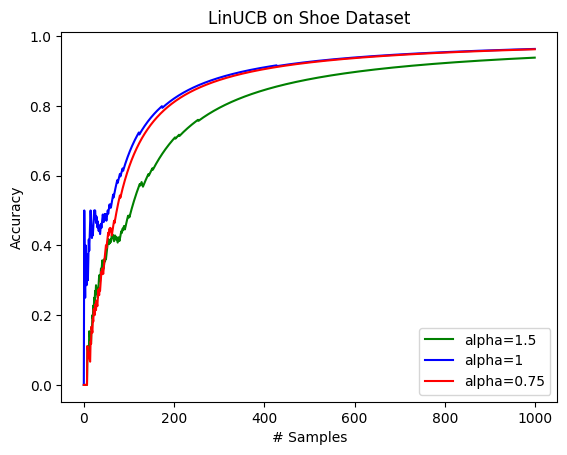

In [12]:
plt.plot(probability15, label="alpha=1.5", color="green")
plt.plot(probability1, label="alpha=1", color="blue")
plt.plot(probability75, label="alpha=0.75", color="red")
plt.legend()
plt.xlabel("# Samples")
plt.ylabel("Accuracy")
plt.title("LinUCB on Shoe Training Set")

Text(0.5, 1.0, 'LinUCB on Shoe Dataset')

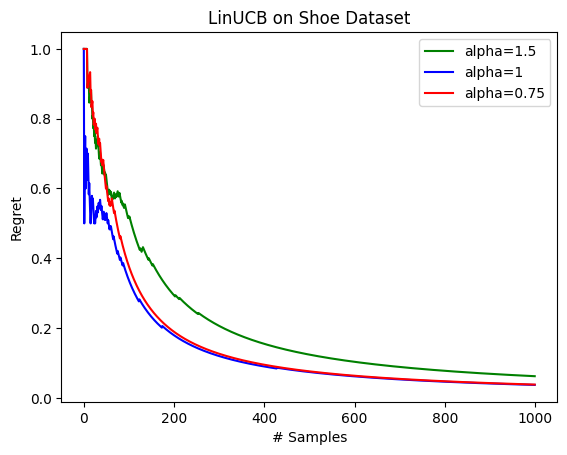

In [13]:
plt.plot(regret15, label="alpha=1.5", color="green")
plt.plot(regret1, label="alpha=1", color="blue")
plt.plot(regret75, label="alpha=0.75", color="red")
plt.legend()
plt.xlabel("# Samples")
plt.ylabel("Regret")
plt.title("LinUCB on Shoe Training Set")

In [16]:
test_probability1, test_regret1 = test_linucb("featurized", policy1)
test_probability15, test_regret15 = test_linucb("featurized", policy15)
test_probability75, test_regret75 = test_linucb("featurized", policy75)

100
100
100


Text(0.5, 1.0, 'LinUCB on Shoe Test Set')

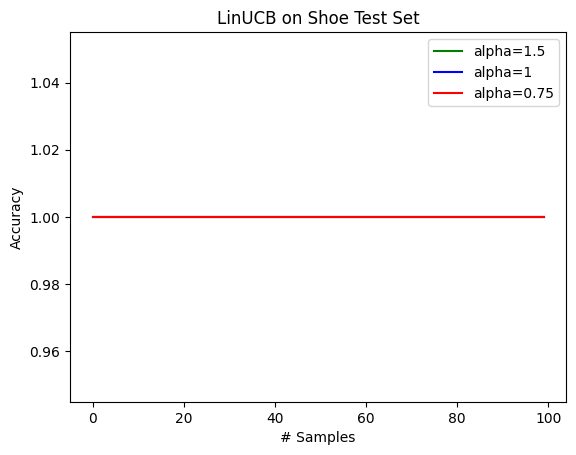

In [17]:
plt.plot(test_probability15, label="alpha=1.5", color="green")
plt.plot(test_probability1, label="alpha=1", color="blue")
plt.plot(test_probability75, label="alpha=0.75", color="red")
plt.legend()
plt.xlabel("# Samples")
plt.ylabel("Accuracy")
plt.title("LinUCB on Shoe Test Set")

Text(0.5, 1.0, 'LinUCB on Shoe Test Set')

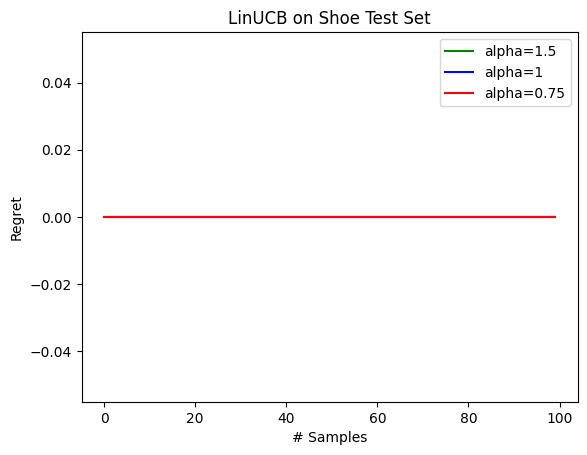

In [18]:
plt.plot(test_regret15, label="alpha=1.5", color="green")
plt.plot(test_regret1, label="alpha=1", color="blue")
plt.plot(test_regret75, label="alpha=0.75", color="red")
plt.legend()
plt.xlabel("# Samples")
plt.ylabel("Regret")
plt.title("LinUCB on Shoe Test Set")